In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Load and preprocess the Adult dataset
def load_adult_data():
    # URLs for the UCI Adult dataset
    # train_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
    # test_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test'

    # Load the training and testing data
    # df_train = pd.read_csv(train_url, header=None, sep=',\s+', engine='python')
    # df_test = pd.read_csv(test_url, header=None, skiprows=1, sep=',\s+', engine='python')
    df_train = pd.read_csv('/content/adult (1).data', header=None, sep=',\s+', engine='python')
    df_test = pd.read_csv('/content/adult.test', header=None, skiprows=1, sep=',\s+', engine='python')

    # Define column names
    column_names = [
        "age", "workclass", "fnlwgt", "education", "education-num",
        "marital-status", "occupation", "relationship", "race", "gender",
        "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"
    ]

    df_train.columns = column_names
    df_test.columns = column_names

    # Combine train and test datasets for consistent preprocessing
    df = pd.concat([df_train, df_test], ignore_index=True)

    # Drop unnecessary columns
    df.drop(["fnlwgt", "workclass", "occupation"], axis=1, inplace=True)

    # Filter rows to include only 'White' and 'Black' in the 'race' column
    df = df[df['race'].isin(['White', 'Black'])]

    # Binarize the 'race' column: Black = 0, White = 1
    df['race'] = df['race'].apply(lambda x: 1 if x == 'White' else 0)

    # Binarize the 'gender' column: Female = 0, Male = 1
    df['gender'] = df['gender'].apply(lambda x: 1 if x == 'Male' else 0)

    # Binarize the 'income' column: '>50K' = 1, '<=50K' = 0
    df['income'] = df['income'].apply(lambda x: 1 if x.startswith('>') else 0)

    # Drop additional columns that won't be used
    df.drop(["education", "native-country"], axis=1, inplace=True)

    # Perform one-hot encoding on categorical features
    categorical_features = list(df.select_dtypes(include=['object']).columns)
    df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

    # Reset index after preprocessing
    df.reset_index(drop=True, inplace=True)

    return df

# Load the dataset
data = load_adult_data()

# Split the dataset into features and labels
X = data.drop("income", axis=1)
y = data["income"]

# Extract sensitive attribute (sex)
sensitive_attribute = X["gender"]
X = X.drop("gender", axis=1)

# Split into training and test sets
X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = train_test_split(
    X, y, sensitive_attribute, test_size=0.2, random_state=42
)

# Train a Random Forest Classifier
# clf = RandomForestClassifier(random_state=42, n_estimators=100)

clf = RandomForestClassifier(random_state=42, n_estimators=10, min_samples_leaf=10)
clf.fit(X_train, y_train)
print("Accuracy:", accuracy_score(y_test, clf.predict(X_test)))


# Make predictions
y_pred_prob = clf.predict_proba(X_test)[:, 1]  # Probability scores for positive class
y_train_pred_prob = clf.predict_proba(X_train)[:, 1]

# Outputs
probability_scores = y_pred_prob
test_labels = y_test.values
sensitive_attribute_test = sensitive_test.values
sensitive_attribute_train = sensitive_train.values

print("Probability scores:", probability_scores)
print("Test labels:", test_labels)
print("Sensitive attribute (gender):", sensitive_attribute_test)

Group1_Prob = probability_scores[sensitive_attribute_test == 1]
Group0_Prob = probability_scores[sensitive_attribute_test == 0]

train_Group1_Prob = y_train_pred_prob[sensitive_attribute_train == 1]
train_Group0_Prob = y_train_pred_prob[sensitive_attribute_train == 0]
train_Group1_labels = y_train[sensitive_attribute_train == 1]
train_Group0_labels = y_train[sensitive_attribute_train == 0]



print(len(Group1_Prob))
print(len(Group0_Prob))


Group1_labels = test_labels[sensitive_attribute_test == 1]
Group0_labels = test_labels[sensitive_attribute_test == 0]

Accuracy: 0.8573735199138859
Probability scores: [0.00088757 0.55997149 0.38807462 ... 0.2787332  0.         0.14541149]
Test labels: [0 0 0 ... 1 0 0]
Sensitive attribute (gender): [0 1 1 ... 1 0 0]
6198
3092


# Function Interval

In [ ]:
import numpy as np

def roc_curve(probabilities, actuals, num_thresholds):
    """
    Compute the ROC curve for a given set of probabilities and actual labels.

    Parameters:
    probabilities (array-like): Probability scores for the positive class.
    actuals (array-like): Ground truth binary labels (0 or 1).
    num_thresholds (int): Number of thresholds to evaluate between 0 and 1.

    Returns:
    roc (list): List of (FPR, TPR) tuples for each threshold.
    thresholds (list): List of thresholds used to compute the ROC curve.
    """
    # Generate thresholds evenly spaced between 0 and 1
    thresholds = np.linspace(0, 1, num_thresholds)

    # Initialize lists to store TPR and FPR values
    roc = []

    # Iterate over each threshold
    for threshold in thresholds:
        # Predicted labels based on the threshold
        predictions = (probabilities >= threshold).astype(int)

        # Calculate True Positives, False Positives, True Negatives, and False Negatives
        TP = np.sum((predictions == 1) & (actuals == 1))
        FP = np.sum((predictions == 1) & (actuals == 0))
        TN = np.sum((predictions == 0) & (actuals == 0))
        FN = np.sum((predictions == 0) & (actuals == 1))

        # Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
        TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
        FPR = FP / (FP + TN) if (FP + TN) > 0 else 0

        # Append the FPR and TPR to the ROC list
        roc.append((FPR, TPR))

    return roc, thresholds


import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

def plot_roc(roc, thresholds):
    """
    Plot the ROC curve.

    Parameters:
    roc (list): List of (FPR, TPR) tuples.
    thresholds (list): List of thresholds corresponding to the ROC points.
    """
    # Extract FPR and TPR values
    fpr = [point[0] for point in roc]
    tpr = [point[1] for point in roc]

    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, 'bo-' , label="ROC Curve", linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC=0.5)")

    # Add labels, legend, and title
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

def plot_roc_curves(roc1, roc2, label1="Model 1", label2="Model 2"):
    """
    Plot two ROC curves for comparison.

    Parameters:
    roc1 (list): List of (FPR, TPR) tuples for the first model.
    roc2 (list): List of (FPR, TPR) tuples for the second model.
    thresholds1 (list): Thresholds corresponding to roc1.
    thresholds2 (list): Thresholds corresponding to roc2.
    label1 (str): Label for the first model's ROC curve.
    label2 (str): Label for the second model's ROC curve.
    """
    # Extract FPR and TPR for each ROC curve
    fpr1, tpr1 = zip(*roc1)
    fpr2, tpr2 = zip(*roc2)

    # Plot ROC curve for the first model
    figure(figsize=(10, 10), dpi=100)
    plt.plot(fpr1, tpr1, label=f"{label1} (AUC: {np.trapz(tpr1, fpr1):.2f})", linestyle='-', marker='o')

    # Plot ROC curve for the second model
    plt.plot(fpr2, tpr2, label=f"{label2} (AUC: {np.trapz(tpr2, fpr2):.2f})", linestyle='--', marker='x')

    # Plot the diagonal line (random classifier)
    # plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")

    # Labels and legend
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("ROC Curve Comparison")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)

    # Show plot
    plt.show()



# Code

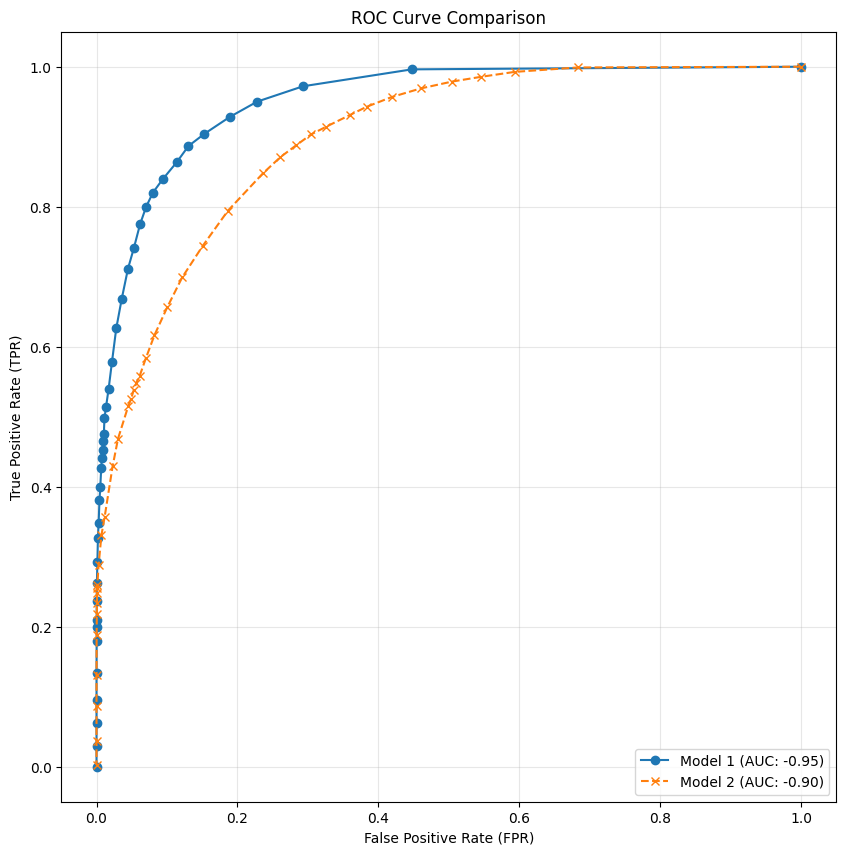

In [ ]:
num_thresholds = 40
roc_up, thresholds_up  = roc_curve(train_Group0_Prob, train_Group0_labels, num_thresholds)
roc_down, thresholds_downn  = roc_curve(train_Group1_Prob, train_Group1_labels, num_thresholds)
# plot_roc(roc_up, thresholds_up)
plot_roc_curves(roc_up , roc_down)



# Functions

In [ ]:
def BoundaryCut(roc_down_point, roc_up, epsilon):
    """
    Determines if any point or linear interpolation between consecutive points in roc_0
    intersects with an L1-norm ball of radius epsilon centered at a given point in roc_1.

    Parameters:
    roc_1_point (tuple): A point (FPR, TPR) from roc_1.
    roc_0 (list): List of points (FPR, TPR) from roc_0.
    epsilon (float): Radius of the L1 norm ball.

    Returns:
    bool: True if any point or linear interpolation in roc_0 intersects with the L1 ball, False otherwise.
    """
    fpr_down, tpr_down = roc_down_point

    # Check points and linear interpolation between consecutive points
    for i in range(len(roc_up) - 1):
        fpr_up_start, tpr_up_start = roc_up[i]
        fpr_up_end, tpr_up_end = roc_up[i + 1]

        # Check if either endpoint is within the L1 ball
        if (abs(fpr_down - fpr_up_start) + abs(tpr_down - tpr_up_start)) <= epsilon:
            return True
        if (abs(fpr_down - fpr_up_end) + abs(tpr_down - tpr_up_end)) <= epsilon:
            return True

        # Parametric interpolation check
        # Parametrize the line segment as: P(t) = (1 - t) * start + t * end, t in [0, 1]
        for t in np.linspace(0, 1, 100):  # Fine-grained sampling
            interpolated_fpr = (1 - t) * fpr_up_start + t * fpr_up_end
            interpolated_tpr = (1 - t) * tpr_up_start + t * tpr_up_end

            # Check if the interpolated point is within the L1 ball
            if (abs(fpr_down - interpolated_fpr) + abs(tpr_down - interpolated_tpr)) <= epsilon:
                return True

    return False

def Cutshift(roc_down_point, roc_up, epsilon):
    """
    Finds the leftmost and rightmost points on roc_0 that intersect with an L1-norm ball
    of radius epsilon centered at a given point in roc_1.

    Parameters:
    roc_1_point (tuple): A point (FPR, TPR) from roc_1.
    roc_0 (list): List of points (FPR, TPR) from roc_0.
    epsilon (float): Radius of the L1 norm ball.

    Returns:
    p_left (tuple): The leftmost point on roc_0 that intersects with the L1 ball.
    p_right (tuple): The rightmost point on roc_0 that intersects with the L1 ball.
    """
    fpr_down, tpr_down = roc_down_point
    intersection_points = []

    # Check points and line segments for intersection
    for i in range(len(roc_up) - 1):
        fpr_up_start, tpr_up_start = roc_up[i]
        fpr_up_end, tpr_up_end = roc_up[i + 1]

        # Check the endpoints for intersection
        if (abs(fpr_down - fpr_up_start) + abs(tpr_down - tpr_up_start)) <= epsilon:
            intersection_points.append((fpr_up_start, tpr_up_start))
        if (abs(fpr_down - fpr_up_end) + abs(tpr_down - tpr_up_end)) <= epsilon:
            intersection_points.append((fpr_up_end, tpr_up_end))

        # Check linear interpolation for intersection
        for t in np.linspace(0, 1, 1000):  # Fine-grained sampling
            interpolated_fpr = (1 - t) * fpr_up_start + t * fpr_up_end
            interpolated_tpr = (1 - t) * tpr_up_start + t * tpr_up_end

            if (abs(fpr_down - interpolated_fpr) + abs(tpr_down - interpolated_tpr)) <= epsilon:
                intersection_points.append((interpolated_fpr, interpolated_tpr))

    # Sort the intersection points by FPR
    intersection_points = sorted(intersection_points, key=lambda p: p[0])

    # Identify the leftmost and rightmost points
    p_left = intersection_points[0] if intersection_points else None
    p_right = intersection_points[-1] if intersection_points else None

    return p_left, p_right


def Upshift(roc_down_point, epsilon):
    """
    Computes the point that is directly epsilon distance above the given roc_1 point.

    Parameters:
    roc_1_point (tuple): A point (FPR, TPR) from roc_1.
    epsilon (float): The vertical distance to shift upward.

    Returns:
    tuple: The point (FPR, TPR + epsilon) resulting from the upshift.
    """
    fpr_down, tpr_down = roc_down_point

    # Shift the TPR upward by epsilon
    shifted_point = (fpr_down, tpr_down + epsilon)

    return shifted_point


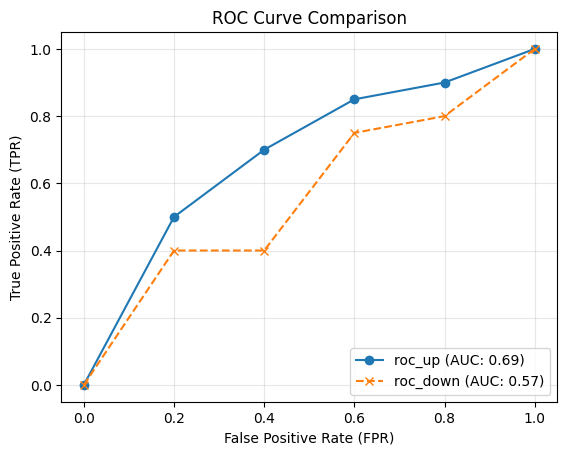

In [ ]:
# Generate two ROC curves for testing
def generate_sample_rocs():
    """
    Generates two sample ROC curves for testing.

    Returns:
    roc_down (list): List of (FPR, TPR) tuples for roc_down.
    roc_up (list): List of (FPR, TPR) tuples for roc_up.
    """
    # ROC for the first model (roc_1)
    roc_up = [(0.0, 0.0), (0.2, 0.5), (0.4, 0.7), (0.6, 0.85), (0.8, 0.9), (1.0, 1.0)]

    # ROC for the second model (roc_0) (shifted lower)
    roc_down = [(0.0, 0.0), (0.2, 0.4), (0.4, 0.4), (0.6, 0.75), (0.8, 0.8), (1.0, 1)]

    return roc_down, roc_up

# Generate ROC curves
roc_down, roc_up = generate_sample_rocs()

# Print the ROC curves
# print("ROC 1:", roc_1)
# print("ROC 0:", roc_0)
plot_roc_curves(roc_up , roc_down, 'roc_up', 'roc_down')


In [ ]:
# Test BoundaryCut
roc_down_point = roc_down[4]  # Pick a point from roc_1
epsilon = 0.2

boundary_cut_result = BoundaryCut(roc_down_point, roc_up, epsilon)
print(f"BoundaryCut result for roc_1[{2}] with epsilon {epsilon}:", boundary_cut_result)


BoundaryCut result for roc_1[2] with epsilon 0.2: True


In [ ]:
# Test Cutshift (only valid if BoundaryCut is True)
if boundary_cut_result:
    p_left, p_right = Cutshift(roc_down_point, roc_up, epsilon)
    print(f"Cutshift results for roc_down[{2}] with epsilon {epsilon}:")
    print("Leftmost point:", p_left)
    print("Rightmost point:", p_right)
else:
    print("BoundaryCut is False. Cutshift not applicable.")


Cutshift results for roc_down[2] with epsilon 0.2:
Leftmost point: (0.6666666666666667, 0.8666666666666667)
Rightmost point: (0.8666666666666667, 0.9333333333333333)


In [ ]:
def FROC(ROC_up, ROC_down, epsilon):
    """
    Implements the Fair ROC (FROC) algorithm to balance fairness across two ROCs.

    Parameters:
    ROC_up (list): List of (FPR, TPR) tuples for the upward ROC (sensitive group 1).
    ROC_down (list): List of (FPR, TPR) tuples for the downward ROC (sensitive group 0).
    epsilon (float): Radius of the L1 norm ball.

    Returns:
    FairROC_up (list): The adjusted FairROC for the upward ROC.
    FairROC_down (list): The adjusted FairROC for the downward ROC.
    """
    # Initialize variables
    i = 0
    k = len(ROC_up)
    FairROC_up = []
    FairROC_down = ROC_down.copy()

    # Iterate over points in ROC_up
    while i < k:
        # Check if ROC_up[i] is within epsilon distance of ROC_down[i]
        l1_distance = abs(ROC_up[i][0] - ROC_down[i][0]) + abs(ROC_up[i][1] - ROC_down[i][1])
        if l1_distance <= epsilon:
            Q_up_i_tilde = ROC_up[i]
            # print(f"Within epsilon distance, keeping ROC_up[{i}] as is:", Q_up_i_tilde)

        elif BoundaryCut(ROC_down[i], ROC_up, epsilon):
            # print("Boundary Cut....")
            # If BoundaryCut is TRUE
            p_left, p_right = Cutshift(ROC_down[i], ROC_up, epsilon)

            if p_left and p_right:  # Ensure valid points are returned
                if ROC_up[i][0] >= ROC_down[i][0]:  # Compare FPR
                    Q_up_i_tilde = p_right
                    # print("=>CutShift Right from:", ROC_up[i], "=>", p_right)
                else:
                    Q_up_i_tilde = p_left
                    # print("=>CutShift Left from:", ROC_up[i], "=>", Q_up_i_tilde)
            else:
                raise ValueError("Cutshift did not return valid points.")

        else:
            # If BoundaryCut is FALSE, perform Upshift
            Q_up_i_tilde = Upshift(ROC_down[i], epsilon)
            # print("=>UpShift from:", ROC_up[i], "=>", Q_up_i_tilde)

        # Append the new point to FairROC_up
        FairROC_up.append(Q_up_i_tilde)
        i += 1

    return FairROC_up, FairROC_down


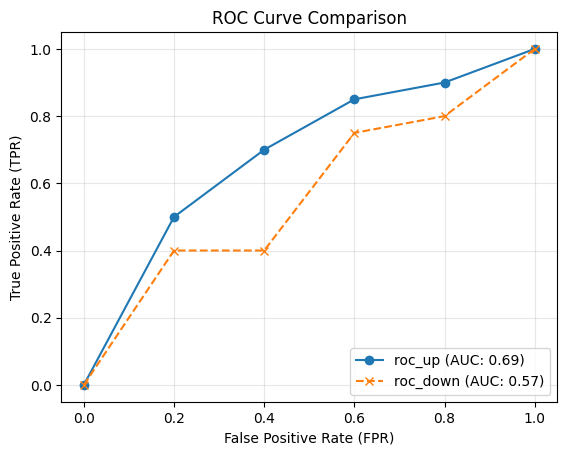

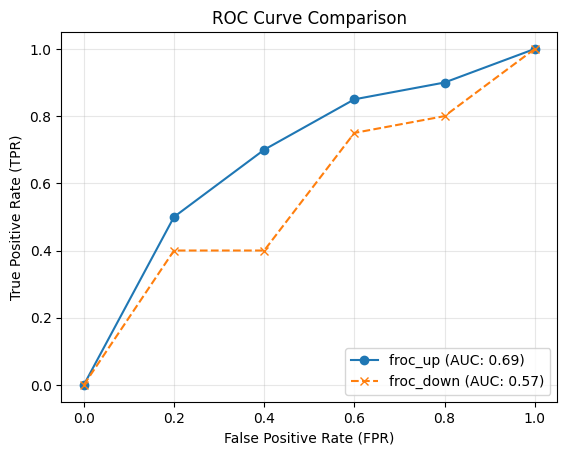

((0.030303030303030304, 0.07575757575757576), (0.4, 0.7))


In [ ]:
roc_down, roc_up = generate_sample_rocs()
plot_roc_curves(roc_up , roc_down, 'roc_up', 'roc_down')

epsilon = 0.5
froc_up, froc_down = FROC(roc_up, roc_down, epsilon)
plot_roc_curves(froc_up , froc_down, 'froc_up', 'froc_down')

print(Cutshift((0.2 , 0.4) , roc_up , epsilon))

# Code

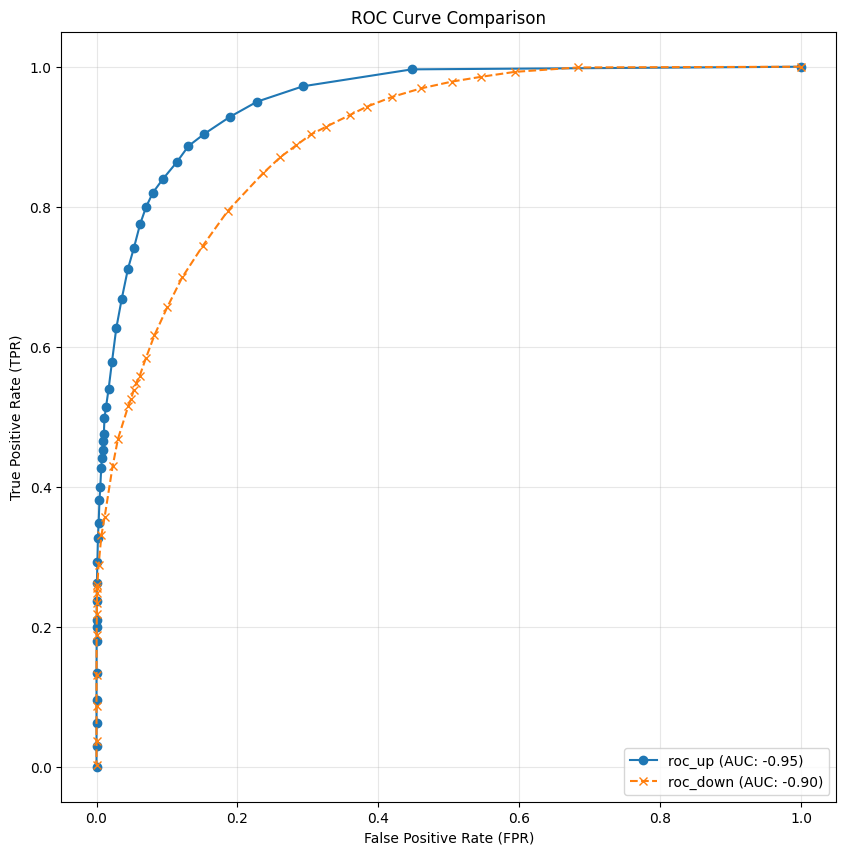

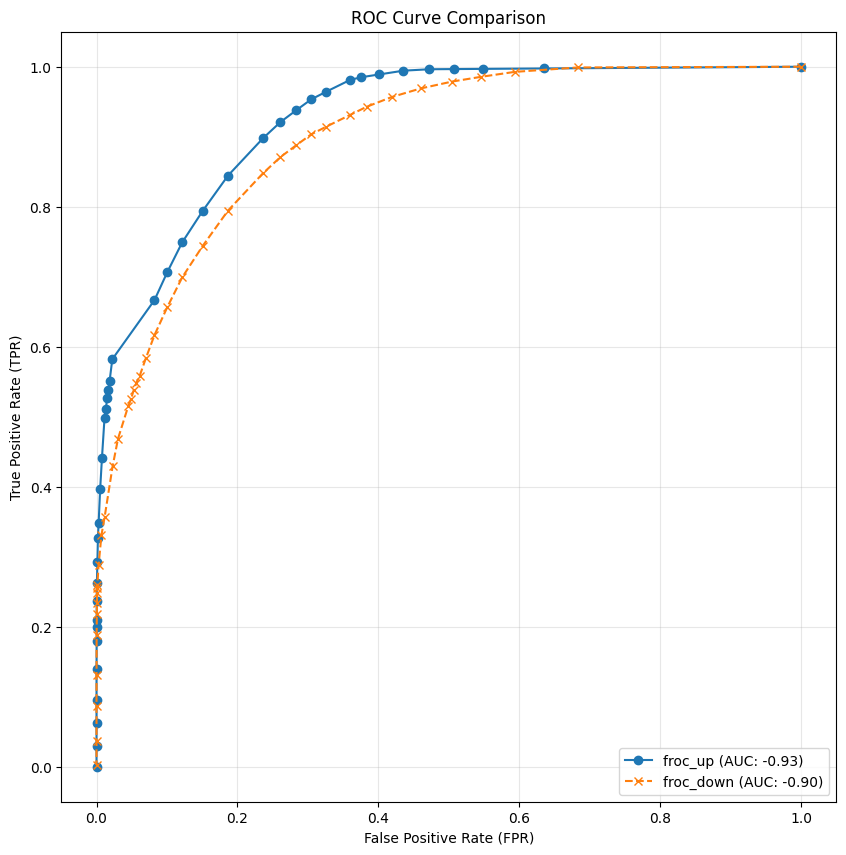

In [ ]:
plot_roc_curves(roc_up , roc_down, 'roc_up', 'roc_down')

epsilon = 0.05
froc_up, froc_down = FROC(roc_up, roc_down, epsilon)
plot_roc_curves(froc_up , froc_down, 'froc_up', 'froc_down')

In [ ]:
## Prior Probability of labels given protected groups
p10 = np.sum(train_Group0_labels == 1)/len(train_Group0_labels)
p00 = np.sum(train_Group0_labels == 0)/len(train_Group0_labels)
p01 = np.sum(train_Group1_labels == 0)/len(train_Group1_labels)
p11 = np.sum(train_Group1_labels == 1)/len(train_Group1_labels)

## Prior Probabilities for Group 0 and Group 1.
prot_0 = len(train_Group0_Prob)/ ( len(train_Group0_Prob) + len(train_Group1_Prob))
prot_1 = len(train_Group1_Prob)/ ( len(train_Group0_Prob) + len(train_Group1_Prob))


def Accuracy( FPR0 , TPR0 , FPR1 , TPR1 ):
  acc = TPR0*p10*prot_0 + TPR1*p11*prot_1 + (1-FPR0)*p00*prot_0 + (1-FPR1)*p01*prot_1
  return acc

In [ ]:
epsilon = 0.06
froc_up, froc_down = FROC(roc_up, roc_down, epsilon)
# plot_roc_curves(froc_up , froc_down, 'froc_up', 'froc_down')


## Prior Probability of labels given protected groups
p10 = np.sum(train_Group0_labels == 1)/len(train_Group0_labels)
p00 = np.sum(train_Group0_labels == 0)/len(train_Group0_labels)
p01 = np.sum(train_Group1_labels == 0)/len(train_Group1_labels)
p11 = np.sum(train_Group1_labels == 1)/len(train_Group1_labels)

## Prior Probabilities for Group 0 and Group 1.
prot_0 = len(train_Group0_Prob)/ ( len(train_Group0_Prob) + len(train_Group1_Prob))
prot_1 = len(train_Group1_Prob)/ ( len(train_Group0_Prob) + len(train_Group1_Prob))


def Accuracy( FPR0 , TPR0 , FPR1 , TPR1 ):
  acc = TPR0*p10*prot_0 + TPR1*p11*prot_1 + (1-FPR0)*p00*prot_0 + (1-FPR1)*p01*prot_1
  return acc

for i in range(num_thresholds):
  print("Accuracy [",i,"] is = ", Accuracy(froc_up[i][0] , froc_up[i][1] , froc_down[i][0] , froc_down[i][1]))

Accuracy [ 0 ] is =  0.2401970019108109
Accuracy [ 1 ] is =  0.49795272571600047
Accuracy [ 2 ] is =  0.563624151104303
Accuracy [ 3 ] is =  0.5962006358701464
Accuracy [ 4 ] is =  0.6244074631457897
Accuracy [ 5 ] is =  0.6544695515010663
Accuracy [ 6 ] is =  0.6809281224600008
Accuracy [ 7 ] is =  0.7019564172186827
Accuracy [ 8 ] is =  0.7146972846840974
Accuracy [ 9 ] is =  0.7339718409092735
Accuracy [ 10 ] is =  0.74745524313075
Accuracy [ 11 ] is =  0.7598326204782786
Accuracy [ 12 ] is =  0.7727717161254098
Accuracy [ 13 ] is =  0.786037201013233
Accuracy [ 14 ] is =  0.8109372193929374
Accuracy [ 15 ] is =  0.8262121502905571
Accuracy [ 16 ] is =  0.837454930089369
Accuracy [ 17 ] is =  0.843347132155223
Accuracy [ 18 ] is =  0.8616906057495987
Accuracy [ 19 ] is =  0.8607293409080421
Accuracy [ 20 ] is =  0.8596481940939245
Accuracy [ 21 ] is =  0.8598478447228346
Accuracy [ 22 ] is =  0.8596243793380267
Accuracy [ 23 ] is =  0.8587926678461437
Accuracy [ 24 ] is =  0.8584164

In [ ]:
t = 19
print(froc_up[t] , froc_down[t])

(0.012764405543398978, 0.47714285714285715) (0.07116279069767442, 0.5821917808219178)


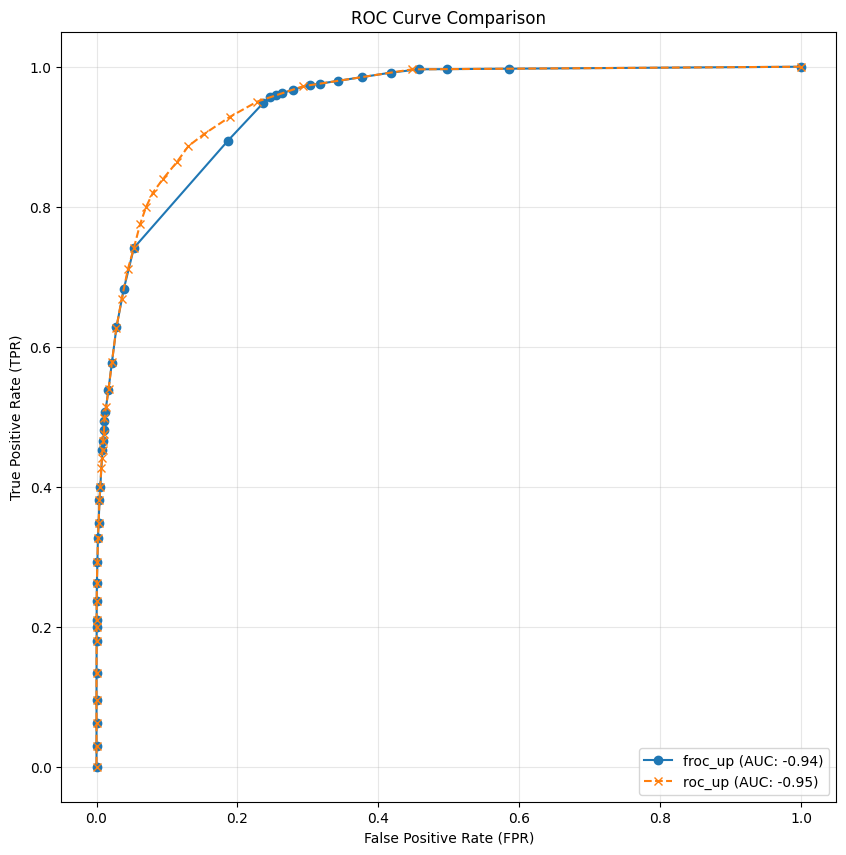

In [ ]:
plot_roc_curves(froc_up , roc_up, 'froc_up', 'roc_up')


In [ ]:
import numpy as np

def Build(probability_scores, ROC_up, target_point):
    """
    Samples from different classifiers to create a new classifier whose FPR, TPR
    are given by the target point.

    Parameters:
    probability_scores (list): Probability scores from the classifier.
    ROC_up (list): List of (FPR, TPR) tuples representing the ROC space.
    target_point (tuple): The target (FPR, TPR) point in the ROC space.

    Returns:
    list: The final classifier C_up.
    """
    # Step 1: Create C_rand
    target_fpr = target_point[0]
    C_rand = np.random.choice([1, 0], size=len(probability_scores), p=[target_fpr, 1 - target_fpr])

    # Step 2: Find the closest point on ROC_up to target_point in the x-axis
    target_fpr = target_point[0]
    j = min(range(len(ROC_up)), key=lambda i: abs(ROC_up[i][0] - target_fpr))
    x, y = ROC_up[j]

    # Step 3: Create C_up using the threshold j / len(ROC_up)
    threshold = j / len(ROC_up)
    C_up = (probability_scores > threshold).astype(int)

    # Step 4: Create C_final
    target_tpr = target_point[1]
    p_rand = (y - target_tpr) / (y - x) if y > x else 0  # Handle division by zero edge case
    C_final = np.where(np.random.rand(len(probability_scores)) < p_rand, C_rand, C_up)

    return C_final

def calculate_tpr_fpr(predicted_labels, true_labels):
    """
    Calculate True Positive Rate (TPR) and False Positive Rate (FPR).

    Parameters:
    predicted_labels (list or array): Predicted binary labels (0 or 1).
    true_labels (list or array): True binary labels (0 or 1).

    Returns:
    tuple: (TPR, FPR) values.
    """
    # Ensure inputs are numpy arrays for easier manipulation
    predicted_labels = np.array(predicted_labels)
    true_labels = np.array(true_labels)

    # True Positives (TP): Predicted as 1, actually 1
    TP = np.sum((predicted_labels == 1) & (true_labels == 1))

    # False Positives (FP): Predicted as 1, actually 0
    FP = np.sum((predicted_labels == 1) & (true_labels == 0))

    # True Negatives (TN): Predicted as 0, actually 0
    TN = np.sum((predicted_labels == 0) & (true_labels == 0))

    # False Negatives (FN): Predicted as 0, actually 1
    FN = np.sum((predicted_labels == 0) & (true_labels == 1))

    # Calculate TPR and FPR
    TPR = TP / (TP + FN) if (TP + FN) > 0 else 0  # Avoid division by zero
    FPR = FP / (FP + TN) if (FP + TN) > 0 else 0  # Avoid division by zero

    return TPR, FPR

def calculate_accuracy(predicted_labels, true_labels):
    """
    Calculate the accuracy of predictions.

    Parameters:
    predicted_labels (list or array): Predicted binary labels (0 or 1).
    true_labels (list or array): True binary labels (0 or 1).

    Returns:
    float: The accuracy of the predictions.
    """
    # Ensure inputs are numpy arrays for easier manipulation
    predicted_labels = np.array(predicted_labels)
    true_labels = np.array(true_labels)

    # Calculate the number of correct predictions
    correct_predictions = np.sum(predicted_labels == true_labels)

    # Calculate accuracy
    accuracy = correct_predictions / len(true_labels) if len(true_labels) > 0 else 0

    return accuracy



In [ ]:
C_fin = Build(Group0_Prob , roc_up , (0.2 , 0.8))


tpr, fpr = calculate_tpr_fpr(C_fin , Group0_labels)
print(fpr , tpr)

acc = calculate_accuracy(C_fin , Group0_labels)
print(acc)





0.19693654266958424 0.8085714285714286
0.803686934023286


In [ ]:
epsilon = 0.05
froc_up, froc_down = FROC(roc_up, roc_down, epsilon)
# plot_roc_curves(froc_up , froc_down, 'froc_up', 'froc_down')

## Prior Probabilities for Group 0 and Group 1.
prot_0 = len(train_Group0_Prob)/ ( len(train_Group0_Prob) + len(train_Group1_Prob))
prot_1 = len(train_Group1_Prob)/ ( len(train_Group0_Prob) + len(train_Group1_Prob))


for i in range(num_thresholds):
  C_final_up = Build(Group0_Prob , roc_up , (froc_up[i][0] , froc_up[i][1]))
  C_final_down = (Group1_Prob > i/len(roc_up)).astype(int)
  print("Accuracy [", i,"] is  = ", prot_0*calculate_accuracy(C_final_up , Group0_labels) + prot_1*calculate_accuracy(C_final_down , Group1_labels))



# def Accuracy( FPR0 , TPR0 , FPR1 , TPR1 ):
#   acc = TPR0*p10*prot_0 + TPR1*p11*prot_1 + (1-FPR0)*p00*prot_0 + (1-FPR1)*p01*prot_1
#   return acc

# for i in range(num_thresholds):
#   print("Accuracy [",i,"] is = ", Accuracy(froc_up[i][0] , froc_up[i][1] , froc_down[i][0] , froc_down[i][1]))

Accuracy [ 0 ] is  =  0.28653761707481096
Accuracy [ 1 ] is  =  0.5477844604415106
Accuracy [ 2 ] is  =  0.5872705485452211
Accuracy [ 3 ] is  =  0.6057695103691513
Accuracy [ 4 ] is  =  0.6236193858132943
Accuracy [ 5 ] is  =  0.6421167298888296
Accuracy [ 6 ] is  =  0.6538083734669703
Accuracy [ 7 ] is  =  0.6659230348079331
Accuracy [ 8 ] is  =  0.7189224186069525
Accuracy [ 9 ] is  =  0.7246705746972917
Accuracy [ 10 ] is  =  0.7360376750855387
Accuracy [ 11 ] is  =  0.7435118749434587
Accuracy [ 12 ] is  =  0.7496409873383536
Accuracy [ 13 ] is  =  0.7738472453844358
Accuracy [ 14 ] is  =  0.7940348346837074
Accuracy [ 15 ] is  =  0.8117714677402101
Accuracy [ 16 ] is  =  0.8287943044811317
Accuracy [ 17 ] is  =  0.834555194479472
Accuracy [ 18 ] is  =  0.8368189080667523
Accuracy [ 19 ] is  =  0.8558260040809589
Accuracy [ 20 ] is  =  0.8570127602804454
Accuracy [ 21 ] is  =  0.8570159957772351
Accuracy [ 22 ] is  =  0.8569094324623321
Accuracy [ 23 ] is  =  0.8558340928229331
Ac